In [1]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [2]:
import tensorflow as tf

# Lista os dispositivos físicos disponíveis
devices = tf.config.list_physical_devices()
print("Dispositivos físicos:", devices)

# Lista apenas as GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Configura TensorFlow para utilizar a memória da GPU de forma dinâmica
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuração de crescimento dinâmico da memória GPU aplicada.")
    except Exception as e:
        print("Erro ao configurar GPU:", e)
else:
    print("Nenhuma GPU foi detectada.")


Dispositivos físicos: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Configuração de crescimento dinâmico da memória GPU aplicada.


Total de imagens encontradas: 981
Mapping de classes (string -> número): {'bom': 0, 'ruim': 1}
Imagens de treino: 785
Imagens de validação: 196


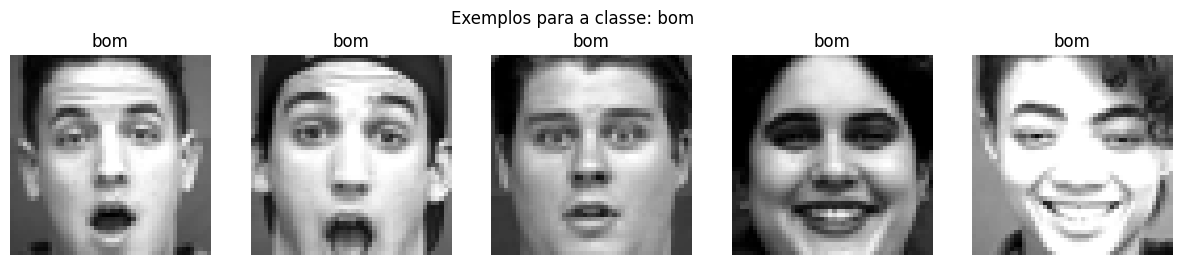

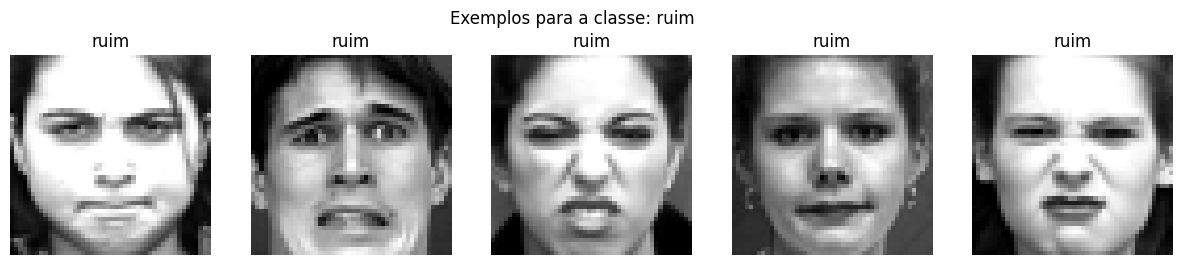

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

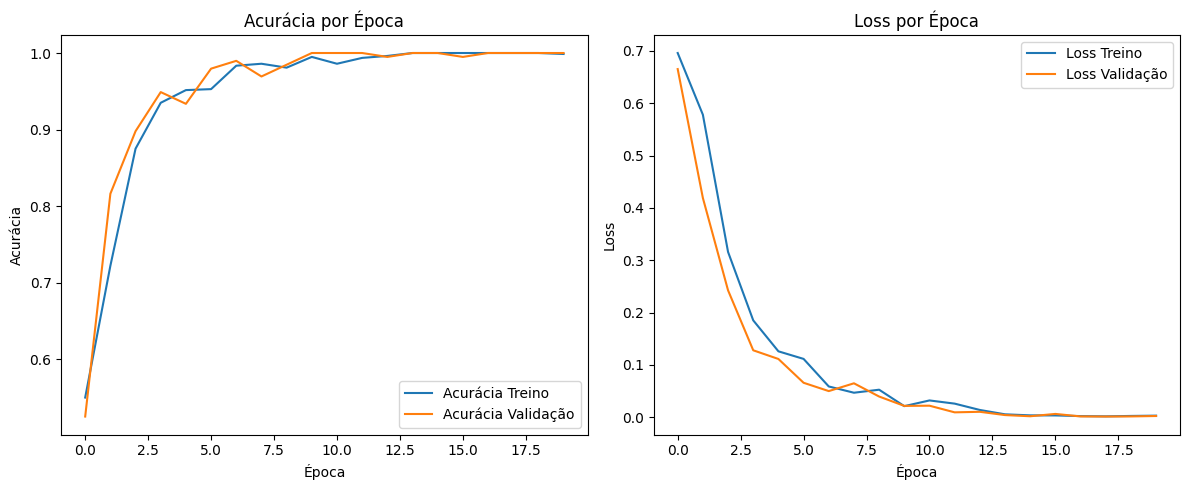

In [4]:
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Configurações gerais e paths
# ===============================
DATA_DIR = r'C:\Users\LIMCI\Desktop\trab_final\ck+\dataset'
IMG_HEIGHT, IMG_WIDTH = 48, 48
BATCH_SIZE = 32
EPOCHS = 20
VALID_SPLIT = 0.2
SEED = 42

# ===============================
# Mapeamento das classes originais para as novas classes
# ===============================
# "bom": happy, surprise; "ruim": sadness, disgust, fear, anger, contempt
mapping = {
    'happy': 'bom',
    'surprise': 'bom',
    'sadness': 'ruim',
    'disgust': 'ruim',
    'fear': 'ruim',
    'anger': 'ruim',
    'contempt': 'ruim'
}

# Para garantir que o mapeamento numérico fique na ordem desejada, defina explicitamente:
# Exemplo: 'bom' -> 0, 'ruim' -> 1
novas_classes = ['bom', 'ruim']
label_to_index = {nome: idx for idx, nome in enumerate(novas_classes)}

# ===============================
# Função para listar imagens e seus rótulos
# ===============================
def listar_imagens_e_rotulos(data_dir, mapping):
    """
    Percorre o diretório, listando os caminhos de imagens e mapeando os rótulos conforme o dicionário mapping.
    """
    image_paths = []
    labels = []
    # Percorre cada pasta (nome da emoção)
    for emotion in os.listdir(data_dir):
        emotion_path = os.path.join(data_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue
        if emotion not in mapping:
            print(f'Ignorando a emoção {emotion} que não está mapeada.')
            continue
        novo_rotulo = mapping[emotion]  # Ex: 'bom' ou 'ruim'
        # Lista as imagens com extensão .png
        for file in os.listdir(emotion_path):
            if file.lower().endswith('.png'):
                image_paths.append(os.path.join(emotion_path, file))
                labels.append(label_to_index[novo_rotulo])
    return image_paths, labels

# Carregar caminhos e rótulos
image_paths, labels = listar_imagens_e_rotulos(DATA_DIR, mapping)
print(f"Total de imagens encontradas: {len(image_paths)}")
print("Mapping de classes (string -> número):", label_to_index)

# ===============================
# Embaralhar os dados e dividir em treino e validação
# ===============================
combined = list(zip(image_paths, labels))
random.seed(SEED)
random.shuffle(combined)
image_paths[:], labels[:] = zip(*combined)

num_total = len(image_paths)
num_val = int(VALID_SPLIT * num_total)
train_paths = image_paths[num_val:]
train_labels = labels[num_val:]
val_paths = image_paths[:num_val]
val_labels = labels[:num_val]

print(f"Imagens de treino: {len(train_paths)}")
print(f"Imagens de validação: {len(val_paths)}")

# ===============================
# Função de leitura e pré-processamento
# ===============================
def ler_e_preprocessar_imagem(path, label):
    """
    Lê a imagem em escala de cinza, decodifica, normaliza e redimensiona.
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)      # Assegura 1 canal (cinza)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normaliza para [0,1]
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image, label

# ===============================
# Criação dos datasets do TensorFlow
# ===============================
train_ds = tf.data.Dataset.from_tensor_slices((list(train_paths), list(train_labels)))
val_ds = tf.data.Dataset.from_tensor_slices((list(val_paths), list(val_labels)))

train_ds = train_ds.map(ler_e_preprocessar_imagem, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(ler_e_preprocessar_imagem, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=1000, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# ===============================
# Visualização de Exemplos
# ===============================
def exibir_exemplos(dataset, n_exemplos=5):
    """
    Exibe exemplos de imagens para cada classe utilizando matplotlib.
    """
    # Prepara dicionário para armazenar exemplos
    exemplos_por_classe = {classe: [] for classe in label_to_index.keys()}
    # Itera no dataset não agrupado
    for imagens, labels in dataset.unbatch():
        # Converter o tensor para numpy e remover dimensões extras
        imagem_np = imagens.numpy().squeeze()
        # Obter o rótulo (string) a partir do valor numérico
        for classe, idx in label_to_index.items():
            if int(labels.numpy()) == idx and len(exemplos_por_classe[classe]) < n_exemplos:
                exemplos_por_classe[classe].append(imagem_np)
        if all(len(v) >= n_exemplos for v in exemplos_por_classe.values()):
            break

    # Exibe os exemplos para cada classe
    for classe, imagens_lista in exemplos_por_classe.items():
        plt.figure(figsize=(15, 3))
        for i, img in enumerate(imagens_lista):
            ax = plt.subplot(1, n_exemplos, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(classe)
            plt.axis("off")
        plt.suptitle(f'Exemplos para a classe: {classe}')
        plt.show()

exibir_exemplos(train_ds, n_exemplos=5)

# ===============================
# Definição da arquitetura da CNN
# ===============================
def criar_modelo():
    model = keras.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Classificação binária: saída entre 0 e 1
    ])
    return model

modelo = criar_modelo()
modelo.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
modelo.summary()

# ===============================
# Treinamento
# ===============================
historico = modelo.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

# ===============================
# Gráficos da evolução do treinamento
# ===============================
def plotar_historico(history):
    plt.figure(figsize=(12, 5))
    
    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Treino')
    plt.plot(history.history['val_loss'], label='Loss Validação')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plotar_historico(historico)

# ===============================
# Teste de predição com imagens fixas para diagnosticar o comportamento
# ===============================
def testar_predicao(imagem_path):
    """
    Função para carregar uma imagem salva, pré-processá-la e realizar a predição.
    """
    img = tf.io.read_file(imagem_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = np.expand_dims(img, axis=0)      # batch dimension
    # Se necessário, garanta a dimensão do canal
    if img.shape[-1] != 1:
        img = np.expand_dims(img, axis=-1)
    
    pred = modelo.predict(img)
    print(f"Predição bruta para {imagem_path}: {pred[0][0]}")
    # Define o limiar padrão 0.5
    classe = 'bom' if pred[0] >= 0.5 else 'ruim'
    print(f"Classificação: {classe}")
    
# Exemplo: teste com imagens salvas (ajuste os caminhos conforme necessário)
# testar_predicao(r'caminho\para\imagem_bom.png')
# testar_predicao(r'caminho\para\imagem_ruim.png')

# ===============================
# Salvar o modelo treinado
# ===============================
modelo.save('modelo_cnn_ckplus.h5')
